## Work on real Merian image
1. Most things are the same in the previous notebook `Merian-tractor-SEP-blob-by-blob.ipynb`.

2. The image `c4d_210307_021334_osj_N708_wide.fits` is not background-subtracted. In `Merian-raw-data-process.ipynb`, I (roughly) estimated a background and subtracted. I think we should discuss about background subtraction & flux calibration in more details. 

    **Update: the keyword `SKYSUB` in image header is the value of sky background. I just subtract this value. The image is scaled to ZP=27.0**


3. In order to fit Merian data with HSC i-band as reference, the i-band output source should be translated to Merian pixel_scale/zeropoint/etc. 

4. I made some updates to `kuaizi.tractor.utils.tractor_blob_by_blob`. Now we can freeze only "b/a" and "position angle" but not effective radius when fitting. In order to do this, use `freeze_dict={'pos': False, 'shape.ab': True, 'shape.phi': True, 'shape.re': False, 'sersicindex': True}`. 

5. The Merian N708 filter is dubbed as `N`. To get the fitting results, use `model_dict['N']` and `getTargetProperty(model_dict['N'], wcs=merian_data.wcs, pixel_scale=0.27, zeropoint=27)`. 

#### Notes on data
Directory: `/tigress/MERIAN/merian/cosmos_stack`

Suffix: image (`osj`), data quality (`osd`), and weights (`osw`)

Cutout is made in `Merian-raw-data-process.ipynb`

In [157]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [5]:
obj_cat = Table.read('./Catalogs/COSMOS_cutouts_tractor_gaap_test.fits')

In [6]:
obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                              '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout'
                             ) for file in obj_cat['dir']]

### Step-by-step

In [7]:
from astropy.convolution import Gaussian2DKernel

In [80]:
channels = 'grizyN'

obj = obj_cat[1]
obj_id = obj['ID']


cutout = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}.fits')) for filt in 'grizy']
cutout += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_N708_deepCoadd.fits"))]

psf_list = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}_psf.fits')) for filt in 'grizy']
psf_list += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_N708_psf.fits"))]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [81]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels) #  
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

# merian_hdu = fits.open('../cosmos_test_1/1/226984/merian/merian_226984_N708.fits')
# merian_data = Data(images=merian_hdu[1].data[np.newaxis, :, :], 
#                    weights=merian_hdu[3].data[np.newaxis, :, :], 
#                    wcs=wcs.WCS(merian_hdu[1].header), 
#                    psfs=[merian_hdu[4].data], channels='N')

In [83]:
images[3].shape

(111, 111)

Text(0.5, 1.0, 'Merian N708')

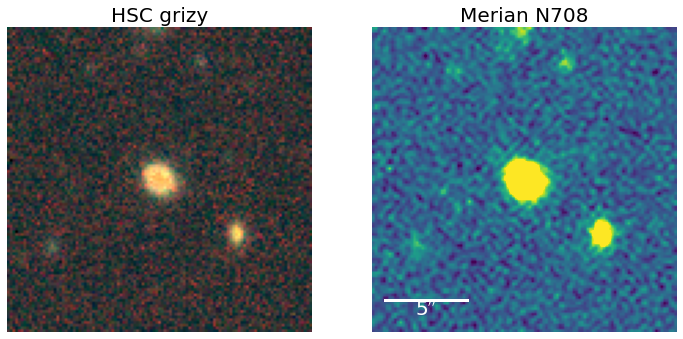

In [84]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(5)

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images[:5,...],
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(hsc_data.images[-1], ax=ax2, pixel_scale=0.168)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

In [85]:
from kuaizi.tractor.utils import makeCatalog, tractor_hsc_sep_blob_by_blob, getTargetProperty
import sys
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')

### `cosmos_43158176442361063` i-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in i-band: 0


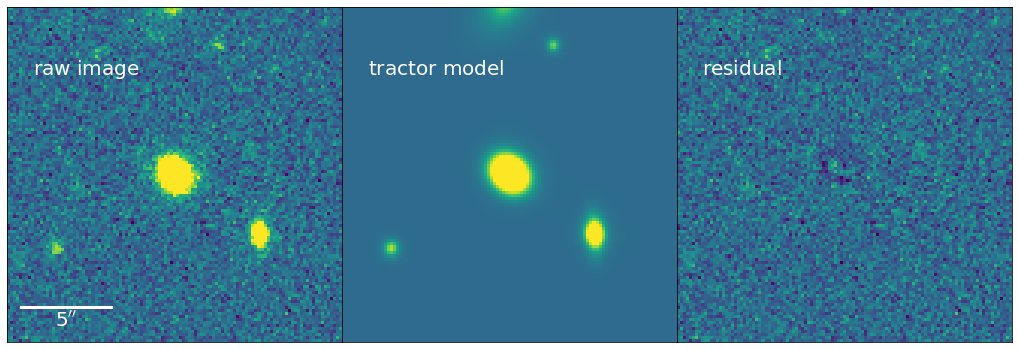

   The chi-square is 12277.257
SersicGalaxy at pixel (55.06, 55.27) with Flux: 123.528 and Galaxy Shape: re=0.69, ab=0.76, phi=50.6, Sersic index 0.627


In [86]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    freeze_dict={'pos': False, 'shape': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=False)

In [87]:
27.0 - 2.5 * np.log10(123.528)

21.770586475095563

In [88]:
obj['i_gaap_mag']

21.68932126387468

In [89]:
import copy
ref_source = copy.deepcopy(model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind])

# # Translate HSC coordinates into Merian coordinates
# x, y = merian_data.wcs.wcs_world2pix(*hsc_data.wcs.wcs_pix2world(ref_source.pos.x, ref_source.pos.y, 0), 0)
# ref_source.pos.x = float(x)
# ref_source.pos.y = float(y)
# ref_source.shape.re *= 0.168 / 0.27 # to Merian pixel scale

### `cosmos_43158176442361063` N-band
    Detected 6 objects
# Total number of objects: 6
# Central object index in N-band: 0
# Progress: 0 / 6
# Progress: 1 / 6
# Progress: 2 / 6
# Progress: 3 / 6
# Progress: 4 / 6
# Progress: 5 / 6


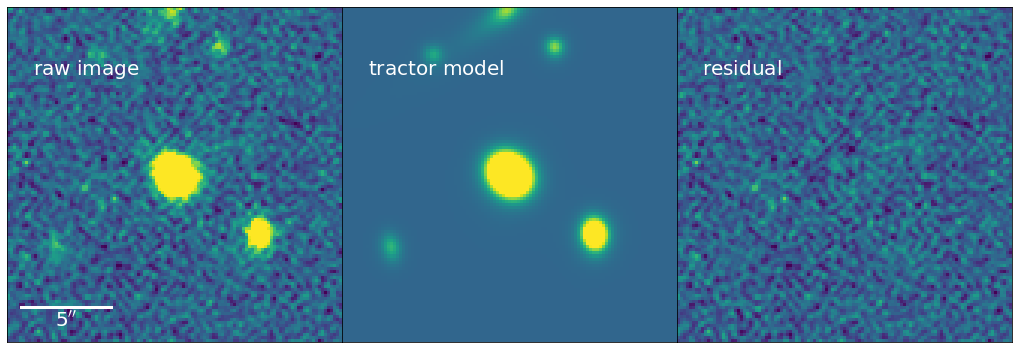

   The chi-square is 12881.932
SersicGalaxy at pixel (55.09, 55.14) with Flux: 108.242 and Galaxy Shape: re=0.64, ab=0.76, phi=50.6, Sersic index 0.627


In [90]:
model_dict['N'] = tractor_hsc_sep_blob_by_blob(
        obj, 'N', hsc_data.channels, hsc_data, 
        ref_source=ref_source,
        freeze_dict={'pos': False, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
        # Since the coordinate system of Merian is different from HSC, we don't fix position. 
        verbose=True)

In [91]:
27.0 - 2.5 * np.log10(108.242) # N708 magnitude

21.914010479566844

In [92]:
obj['i_gaap_mag'] - obj['N708_gaap_mag']

-0.053744597779697756

In [93]:
2.5 * np.log10(108.242 / 123.528)

-0.14342400447128265

# Batch fitting (forced-photometry, blob-by-blob)

In [145]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row

In [146]:
meas_cat = initialize_meas_cat(obj_cat)

In [147]:
channels = 'grizyN'
ref_filt = 'i'
forced_channels = [filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[0:10]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['ID']
    
    cutout = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}.fits')) for filt in 'grizy']
    cutout += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_N708_deepCoadd.fits"))]

    psf_list = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}_psf.fits')) for filt in 'grizy']
    psf_list += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_N708_psf.fits"))]

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, data.channels, data, 
        freeze_dict={'pos': False, 'shape': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=False)

    for filt in forced_channels:
        pos = False if filt == 'N' else True
        model_dict[filt] = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data, 
            ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': pos, 'shape': True, 'sersicindex': True}, # don't fix shape/sersic
            verbose=False, )
        
    # Write to catalog
    _write_to_row(meas_cat[k], model_dict)
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

### Tractor modeling for obj 0
   The chi-square is 2001.3229
   The chi-square is 1995.8333
   The chi-square is 1858.3922
   The chi-square is 1815.386
   The chi-square is 1909.0203
   The chi-square is 1828.4727
### Tractor modeling for obj 1
   The chi-square is 12277.257
   The chi-square is 12527.294
   The chi-square is 12578.182
   The chi-square is 12362.372
   The chi-square is 12441.722
   The chi-square is 12971.418
### Tractor modeling for obj 2
   The chi-square is 9919.156
   The chi-square is 9575.094
   The chi-square is 9656.101
   The chi-square is 9331.739
   The chi-square is 9683.835
   The chi-square is 11126.988
### Tractor modeling for obj 3
   The chi-square is 6444.3296
   The chi-square is 6295.214
   The chi-square is 6177.064
   The chi-square is 6463.6904
   The chi-square is 5994.09
   The chi-square is 8847.781
### Tractor modeling for obj 4
   The chi-square is 12487.39
   The chi-square is 12192.379
   The chi-square is 11589.535
   The chi-square is

In [187]:
Table.read('./Catalogs/tractor_test_output_{low}_{high}.fits')

ID,x,x_ivar,y,y_ivar,flux [6],flux_ivar [6],ab,ab_ivar,phi,phi_ivar,sersic,sersic_ivar,type
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes15
43158176442360746,21.41028639194869,1394.3544921875,21.069631288873705,1113.5023193359375,0.41774241431603354 .. 0.7377849653202285,21081.024081019834 .. 37386.080310832425,0.7551515023124021,839.013427734375,130.52477295571524,0.03482381999492645,1.5629855598669862,30.220829010009766,
43158176442361063,55.059557718501146,789.5800170898438,55.26939873833259,1057.8565673828125,0.6681822838357679 .. 1.789447671434636,9634.216611001326 .. 19846.60163669619,0.7616165298805245,4761.06396484375,50.610398851171816,0.2615511417388916,0.6267309234269144,1274.9615478515625,
43158176442379695,47.68068909420298,3881.876953125,47.95595777379162,9565.853515625,0.8453472151419331 .. 2.392403020065808,8832.262500717441 .. 25692.97113708522,0.25928280266559733,27189.78515625,72.01893674752111,18.41582489013672,1.0,0.0,
43158176442380949,37.330453549833784,6511.9482421875,36.581583390474655,8529.431640625,1.909408677273021 .. 3.7065045582663125,8391.001134918399 .. 22784.662594442863,0.5543088499470775,12918.2890625,62.90673531658272,2.4953055381774902,1.8809930939262733,651.4357299804688,
43158176442381535,52.183373498363416,84782.3203125,51.59861227414655,55306.390625,4.092719698589082 .. 10.269141977158958,9598.83946508899 .. 17471.662986189665,0.29840268639254086,290210.875,146.9473172238936,186.43264770507812,0.824752104344183,22670.693359375,
43158176442382941,78.36463774146235,7744.02001953125,78.26064125524668,12303.9130859375,2.3765458564110173 .. 7.020040890176356,8673.232396528767 .. 13223.1868702006,0.5537181694192358,90123.3671875,116.13547421828005,21.545228958129883,0.5934697711118302,24386.22265625,
43158176442383802,38.81774075864223,214.9178924560547,39.17858385460104,207.2129364013672,0.2768385094253954 .. 0.49872761322377485,21515.136362707166 .. 31969.538577303287,0.7447624217034607,688.2015991210938,144.10908277779262,0.037031784653663635,0.5349203135601135,138.7440185546875,
43158180737322463,55.73558331633285,8131.35546875,55.34587095345048,2737.736572265625,0.751607253843434 .. 2.361279917173582,17752.18955381907 .. 22216.6995637601,0.32381489013236037,25874.412109375,164.753503909611,14.50635051727295,0.8204745602802034,2439.810302734375,
43158180737340070,40.34078567453581,2749.10791015625,40.19147671056732,2077.495849609375,0.6052838417873513 .. 1.5591808261928246,18585.4849754902 .. 24863.094594990616,0.7953526295781049,6616.322265625,147.56947931539997,0.23851262032985687,0.6060255629481522,1371.0836181640625,


In [186]:
meas_cat

ID,x,x_ivar,y,y_ivar,flux [6],flux_ivar [6],ab,ab_ivar,phi,phi_ivar,sersic,sersic_ivar,type,mag [6]
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes15,float64
0,21.41028639194869,1394.3544921875,21.069631288873705,1113.5023193359375,0.41774241431603354 .. 0.7377849653202285,21081.024081019834 .. 37386.080310832425,0.7551515023124021,839.013427734375,130.52477295571524,0.03482381999492645,1.5629855598669862,30.220829010009766,,23.44772856902987 .. 22.830175497823834
0,55.059557718501146,789.5800170898438,55.26939873833259,1057.8565673828125,0.6681822838357679 .. 1.789447671434636,9634.216611001326 .. 19846.60163669619,0.7616165298805245,4761.06396484375,50.610398851171816,0.2615511417388916,0.6267309234269144,1274.9615478515625,,22.93776260853896 .. 21.868202492751116
0,47.68068909420298,3881.876953125,47.95595777379162,9565.853515625,0.8453472151419331 .. 2.392403020065808,8832.262500717441 .. 25692.97113708522,0.25928280266559733,27189.78515625,72.01893674752111,18.41582489013672,1.0,0.0,,22.68241218428939 .. 21.55291414506267
0,37.330453549833784,6511.9482421875,36.581583390474655,8529.431640625,1.909408677273021 .. 3.7065045582663125,8391.001134918399 .. 22784.662594442863,0.5543088499470775,12918.2890625,62.90673531658272,2.4953055381774902,1.8809930939262733,651.4357299804688,,21.797752770308136 .. 21.07758865361434
0,52.183373498363416,84782.3203125,51.59861227414655,55306.390625,4.092719698589082 .. 10.269141977158958,9598.83946508899 .. 17471.662986189665,0.29840268639254086,290210.875,146.9473172238936,186.43264770507812,0.824752104344183,22670.693359375,,20.96996999553596 .. 19.97116460428632
0,78.36463774146235,7744.02001953125,78.26064125524668,12303.9130859375,2.3765458564110173 .. 7.020040890176356,8673.232396528767 .. 13223.1868702006,0.5537181694192358,90123.3671875,116.13547421828005,21.545228958129883,0.5934697711118302,24386.22265625,,21.560134503502873 .. 20.38415089548523
0,38.81774075864223,214.9178924560547,39.17858385460104,207.2129364013672,0.2768385094253954 .. 0.49872761322377485,21515.136362707166 .. 31969.538577303287,0.7447624217034607,688.2015991210938,144.10908277779262,0.037031784653663635,0.5349203135601135,138.7440185546875,,23.894433744464532 .. 23.255341463458922
0,55.73558331633285,8131.35546875,55.34587095345048,2737.736572265625,0.751607253843434 .. 2.361279917173582,17752.18955381907 .. 22216.6995637601,0.32381489013236037,25874.412109375,164.753503909611,14.50635051727295,0.8204745602802034,2439.810302734375,,22.810022592819898 .. 21.567131316422135
0,40.34078567453581,2749.10791015625,40.19147671056732,2077.495849609375,0.6052838417873513 .. 1.5591808261928246,18585.4849754902 .. 24863.094594990616,0.7953526295781049,6616.322265625,147.56947931539997,0.23851262032985687,0.6060255629481522,1371.0836181640625,,23.04510229884763 .. 22.017758786332447


In [149]:
meas_cat.write('./Catalogs/tractor_test_output.fits')

In [153]:
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'].data)

In [163]:
obj_cat['mag'] = np.hstack([obj_cat[f'{filt}_gaap_mag'].data[:, None] for filt in list('grizy') + ['N708']])

In [178]:
obj_cat['mag_tractor'] = 22.5 - 2.5 * np.log10(np.hstack(
    [obj_cat[f'{filt}_tractor_flux'].data[:, None] for filt in list('grizy') + ['N708']]))

Text(0, 0.5, 'Tractor')

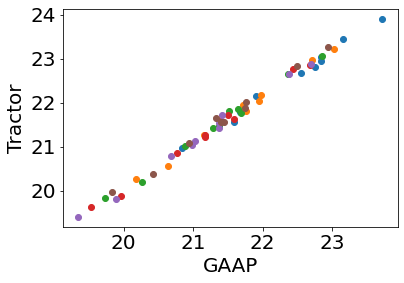

In [170]:
for i in range(6):
    plt.scatter(obj_cat[:10]['mag'][:, i], meas_cat[:10]['mag'][:, i])

plt.xlabel('GAAP')
plt.ylabel('Tractor')

Text(0, 0.5, 'GAAP - Tractor')

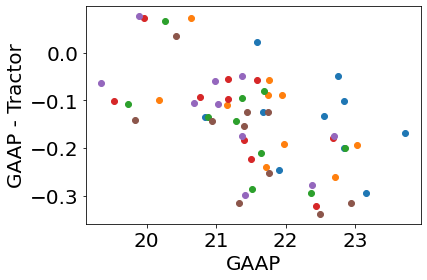

In [172]:
for i in range(6):
    plt.scatter(obj_cat[:10]['mag'][:, i], obj_cat[:10]['mag'][:, i] - meas_cat[:10]['mag'][:, i])

plt.xlabel('GAAP')
plt.ylabel('GAAP - Tractor')

In [ ]:
01234 5
grizy N708

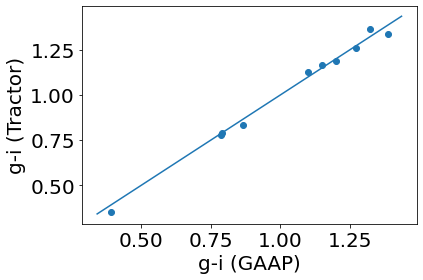

In [182]:
plt.scatter(obj_cat[:10]['mag'][:, 0] - obj_cat[:10]['mag'][:, 2], 
            meas_cat[:10]['mag'][:, 0] - meas_cat[:10]['mag'][:, 2])

plt.xlabel('g-i (GAAP)')
plt.ylabel('g-i (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

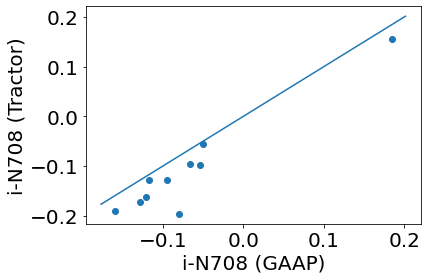

In [185]:
plt.scatter(obj_cat[:10]['mag'][:, 2] - obj_cat[:10]['mag'][:, 5], 
            meas_cat[:10]['mag'][:, 2] - meas_cat[:10]['mag'][:, 5])

plt.xlabel('i-N708 (GAAP)')
plt.ylabel('i-N708 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

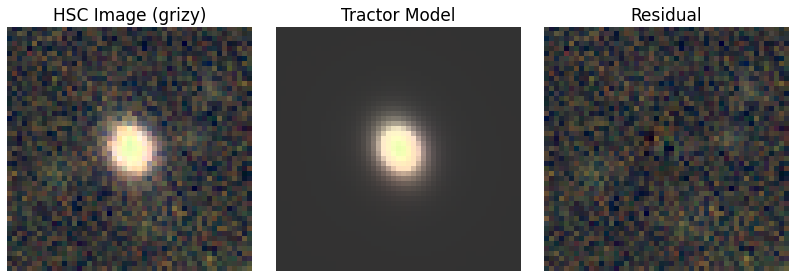

In [174]:
# ### Make figures into a PDF file (slow)
# from fpdf import FPDF
# pdf = FPDF()
# pdf.add_page()
# for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
#     pdf.image(image, 21, 11 + k * 55, 167, 55)
# pdf.output(obj_name + "_sep_tractor.pdf", "F")

# Visualize our model
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

model_rgb = scarlet.display.img_to_rgb(
    model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

res_rgb = scarlet.display.img_to_rgb(
    data.images - model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(img_rgb, origin='lower')
ax2.imshow(model_rgb, origin='lower')
ax3.imshow(res_rgb, origin='lower')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

ax1.set_title('HSC Image (grizy)', fontsize=17)
ax2.set_title('Tractor Model', fontsize=17)
ax3.set_title('Residual', fontsize=17)

plt.subplots_adjust(wspace=0.1)
# plt.savefig(obj_name + '_sep_tractor_rgb.png', 
#             bbox_inches='tight', 
#             metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})


#clear_output()
#plt.close()